<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/soft_sensor_deveopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft sensor development

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Step 1. Initialization, data onboarding and exploration

Initialize libraries, set random number state for reproducibility, and the directory where the figures should be saved to.

In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set random state
np.random.seed(42)

# Set directory for figures
figs_dir = "figures" if os.path.isdir("figures") else ""

Fetch data from kaggle:

In [548]:
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

Load data to memory

In [549]:
data = pd.read_csv(data_path)
print(data.shape)

(737453, 24)


Format the data; date column as datetime objects, other columns as decimal numbers.

In [550]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

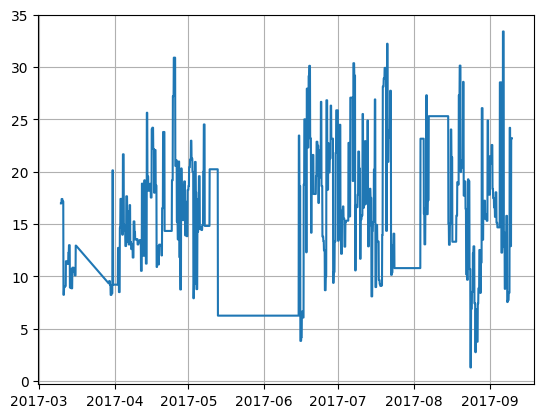

In [551]:
plt.plot(data['date'], data['% Silica Feed'])
plt.grid(which='both')

In [552]:
low_freq_variables = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate', '% Silica Concentrate']
low_freq_features = ['% Iron Feed', '% Silica Feed']
high_freq_features = [c for c in data.columns if c not in [*low_freq_variables, 'date']]
predicted_variables = ['% Silica Concentrate']

---

## Step 2. Data pretreatment

Handle missing data

In [553]:
print(data.shape)
# Find datetime stamps with less than 180 entries
for date in data['date'].unique(): 

    # Count current datetime entries
    num_entries = len(data[data['date'] == date])
    if (num_missing_rows := 180 - num_entries) > 0: 
        
        # Add missing entries to the start of the current datetime run
        first_index = data['date'][data['date'] == date].idxmin()
        missing_rows = pd.DataFrame([data.iloc[first_index, :].to_numpy()] * num_missing_rows, columns=data.columns)

        # Add copies of the first instance of the datetime 
        data = pd.concat([
            data[data['date'] < date], 
            missing_rows, 
            data[data['date'] >= date], 
        ], ignore_index = True)

(737453, 24)


### Fixing the datetime index

The data datetime index is missing minute and second values. 

In [554]:
# Create proper datetime index spaced by 20 seconds
data['date_hour'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H')
data['within_hour_idx'] = data.groupby('date_hour').cumcount()
data['datetime'] = data['date_hour'] + pd.to_timedelta(data['within_hour_idx'] * 20, unit='s')

# Set the datetime as data index
data = data.set_index('datetime')
data.index.name = None
data = data.sort_index()
data = data.drop(columns=['date', 'within_hour_idx', 'date_hour'])

# Resample the data 
print(data[data.columns[:3]].head())
print(data[data.columns[:3]].tail())

print(data.shape)
print(data.dropna().shape)

                     % Iron Feed  % Silica Feed  Starch Flow
2017-03-10 01:00:00         55.2          16.98      3019.53
2017-03-10 01:00:20         55.2          16.98      3019.53
2017-03-10 01:00:40         55.2          16.98      3019.53
2017-03-10 01:01:00         55.2          16.98      3019.53
2017-03-10 01:01:20         55.2          16.98      3019.53
                     % Iron Feed  % Silica Feed  Starch Flow
2017-09-09 23:58:20        49.75           23.2      2710.94
2017-09-09 23:58:40        49.75           23.2      2692.01
2017-09-09 23:59:00        49.75           23.2      2692.20
2017-09-09 23:59:20        49.75           23.2      1164.12
2017-09-09 23:59:40        49.75           23.2      1164.12
(737460, 23)
(737460, 23)


### Resampling the data

Resample the data to the frequency `sampling_freq`.

In [555]:
# Aggregation rules
# agg_rules = {col : ['mean', 'std', 'min', 'max'] for col in high_freq_features}
# agg_rules.update({col: ['mean'] for col in low_freq_features + predicted_variables})

# Decide sampling frequency and resample the data
sampling_freq = '1H' # For example: 1H, 5MIN, 20S

data = data.resample(sampling_freq).mean()
#data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Resample the data 
print(data[data.columns[:6]].head())
print(data[data.columns[:3]].tail())

print(data.shape)
data = data.dropna()
print(data.shape)

                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
2017-03-10 01:00:00         55.2          16.98  3157.855192  578.074922   
2017-03-10 02:00:00         55.2          16.98  3133.256389  537.219661   
2017-03-10 03:00:00         55.2          16.98  3479.482944  591.906744   
2017-03-10 04:00:00         55.2          16.98  3228.036436  593.170106   
2017-03-10 05:00:00         55.2          16.98  3327.280739  619.710806   

                     Ore Pulp Flow  Ore Pulp pH  
2017-03-10 01:00:00     398.652022    10.111918  
2017-03-10 02:00:00     399.871822    10.129742  
2017-03-10 03:00:00     398.763806    10.048403  
2017-03-10 04:00:00     399.866983     9.918614  
2017-03-10 05:00:00     399.615089     9.746029  
                     % Iron Feed  % Silica Feed  Starch Flow
2017-09-09 19:00:00        49.75           23.2  3327.047776
2017-09-09 20:00:00        49.75           23.2  4225.800333
2017-09-09 21:00:00        49.75           23.2  2808.214692

We start by dropping bad time windows from the data

In [556]:
from datetime import datetime as dt
# Usable time windows in the data

dt_format = '%Y-%m-%d %H:%M:%S'
good_windows = [
    {'start': dt.strptime("2017-03-31 01:00:00", dt_format), 'end': dt.strptime("2017-05-13 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-06-15 01:00:00", dt_format), 'end': dt.strptime("2017-07-24 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-08-16 01:00:00", dt_format), 'end': dt.strptime("2017-10-01 23:59:59", dt_format)}
]

# Reconstruct the dataset from the usable sets
data_batches = [data.loc[(data.index > w['start']) & (data.index < w['end'])] for w in good_windows]
data = pd.concat(data_batches)
print(data.shape)

(2610, 23)


---

## Step 3. Data visualization and PCA


### Fitting the model

Fitting the PCA model

In [557]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize the data for PCA
scaler = StandardScaler()
PCA_data = pd.DataFrame(scaler.fit_transform(data))

# Fit the PCA model
pca = PCA().fit(PCA_data)

print(data)

                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
2017-03-31 02:00:00        54.30          20.14  2078.574419  466.845511   
2017-03-31 03:00:00        54.30          20.14  2178.594889  518.840328   
2017-03-31 04:00:00        54.30          20.14  2295.332778  550.029539   
2017-03-31 05:00:00        54.30          20.14  2232.920667  559.358472   
2017-03-31 06:00:00        54.30          20.14  2234.601778  554.378756   
...                          ...            ...          ...         ...   
2017-09-09 19:00:00        49.75          23.20  3327.047776  497.211189   
2017-09-09 20:00:00        49.75          23.20  4225.800333  508.963856   
2017-09-09 21:00:00        49.75          23.20  2808.214692  517.748822   
2017-09-09 22:00:00        49.75          23.20  3191.497672  492.511228   
2017-09-09 23:00:00        49.75          23.20  3638.543653  460.769950   

                     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
2017-03-31 02:00:0

### Explained variance

Visualizing the the principal components values and cumulative explained

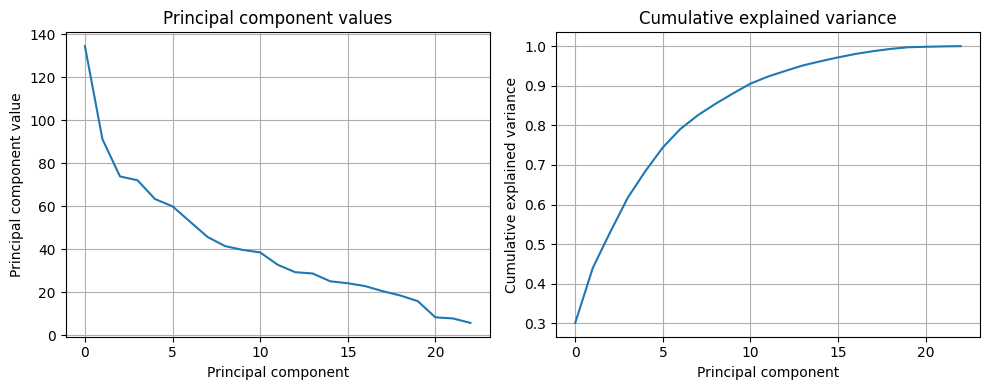

In [558]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots

Next we create biplots for the PCA

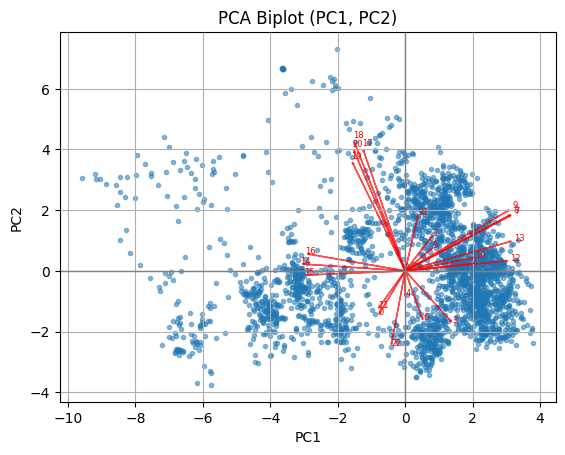

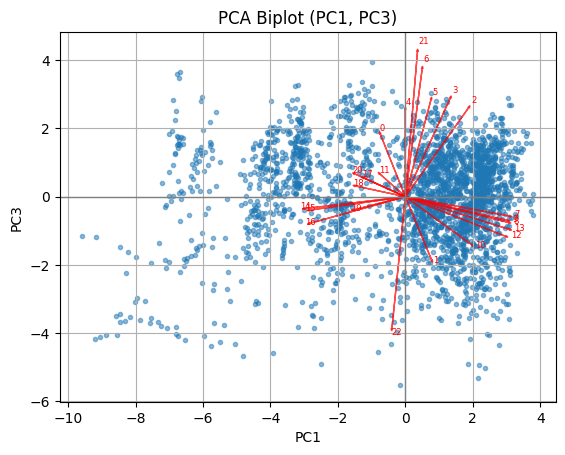

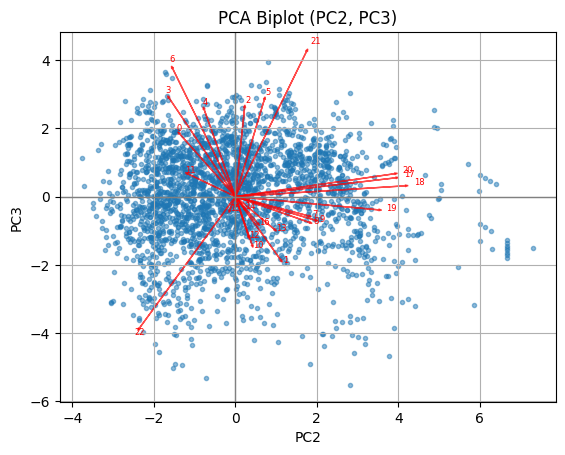

In [559]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    if figs_dir: plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

### Data correlations and distributions

We visualize data correlations and variable distributions

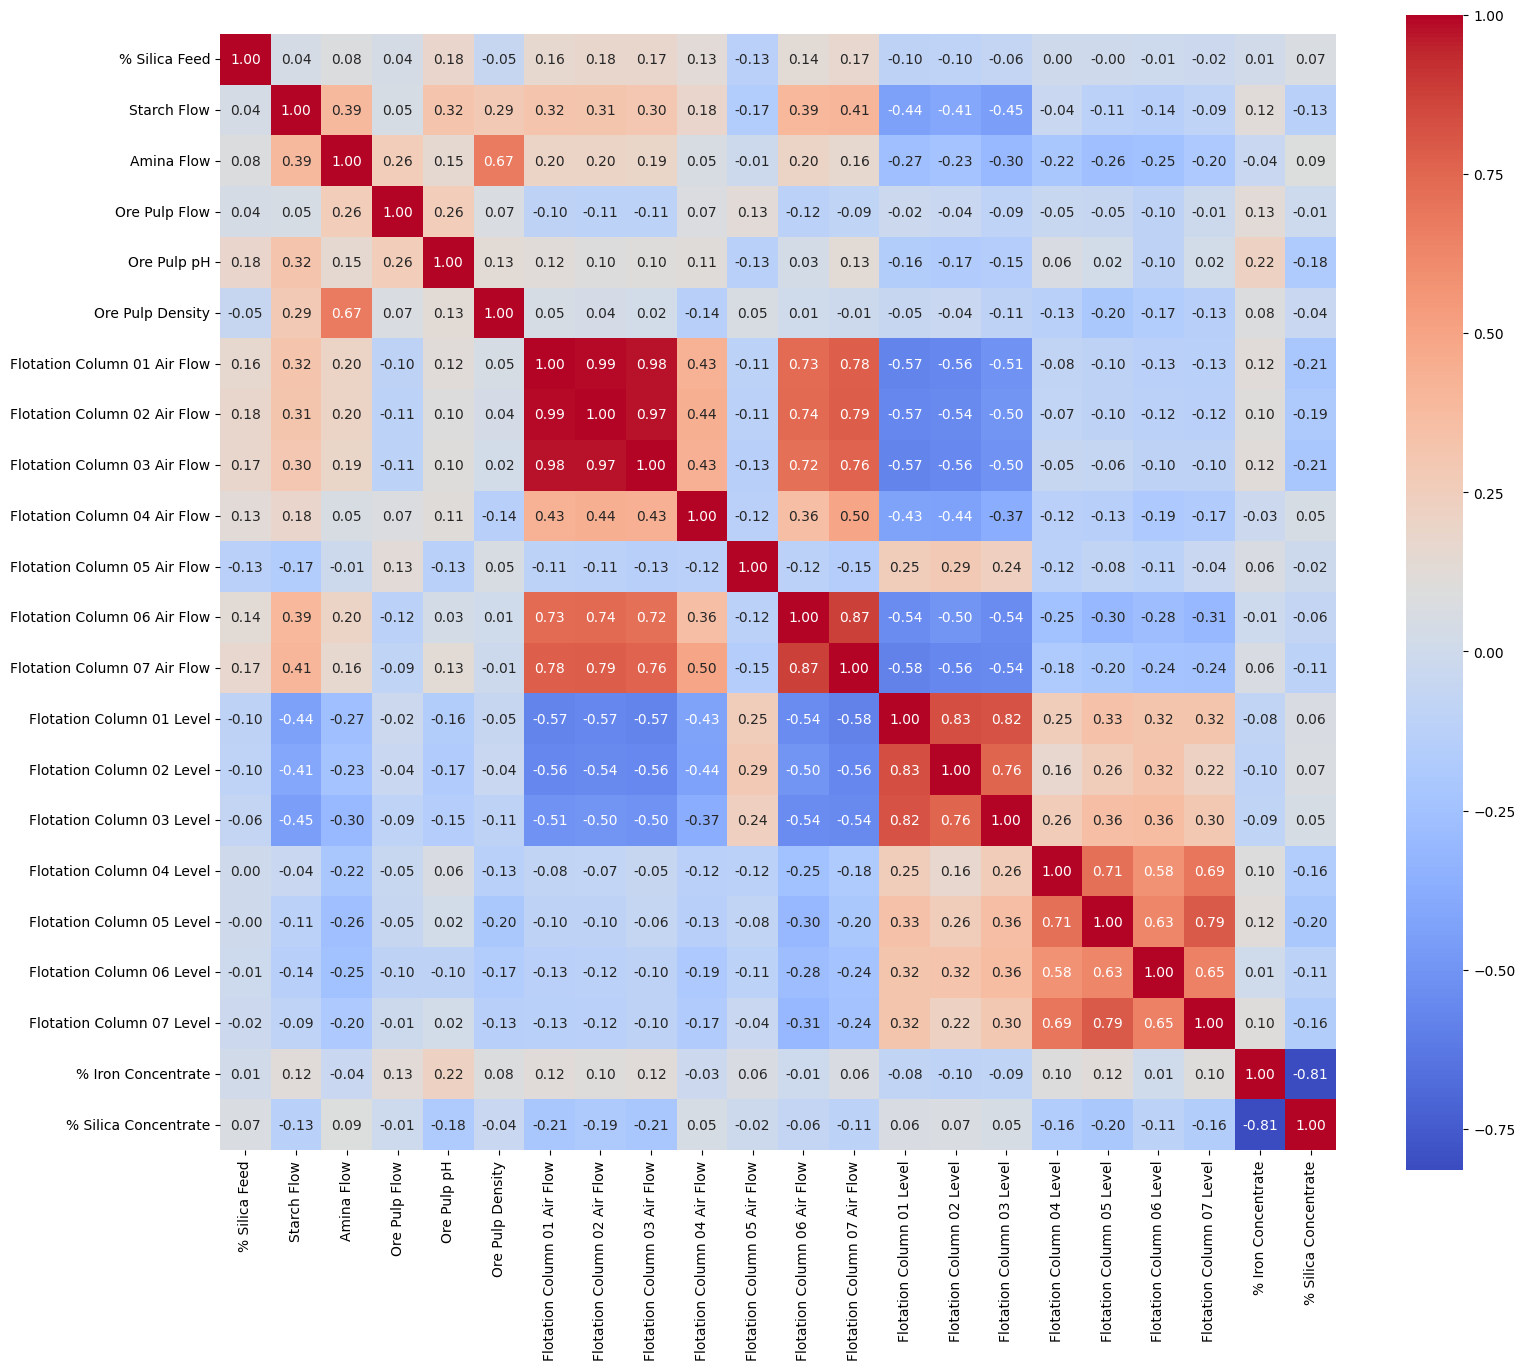

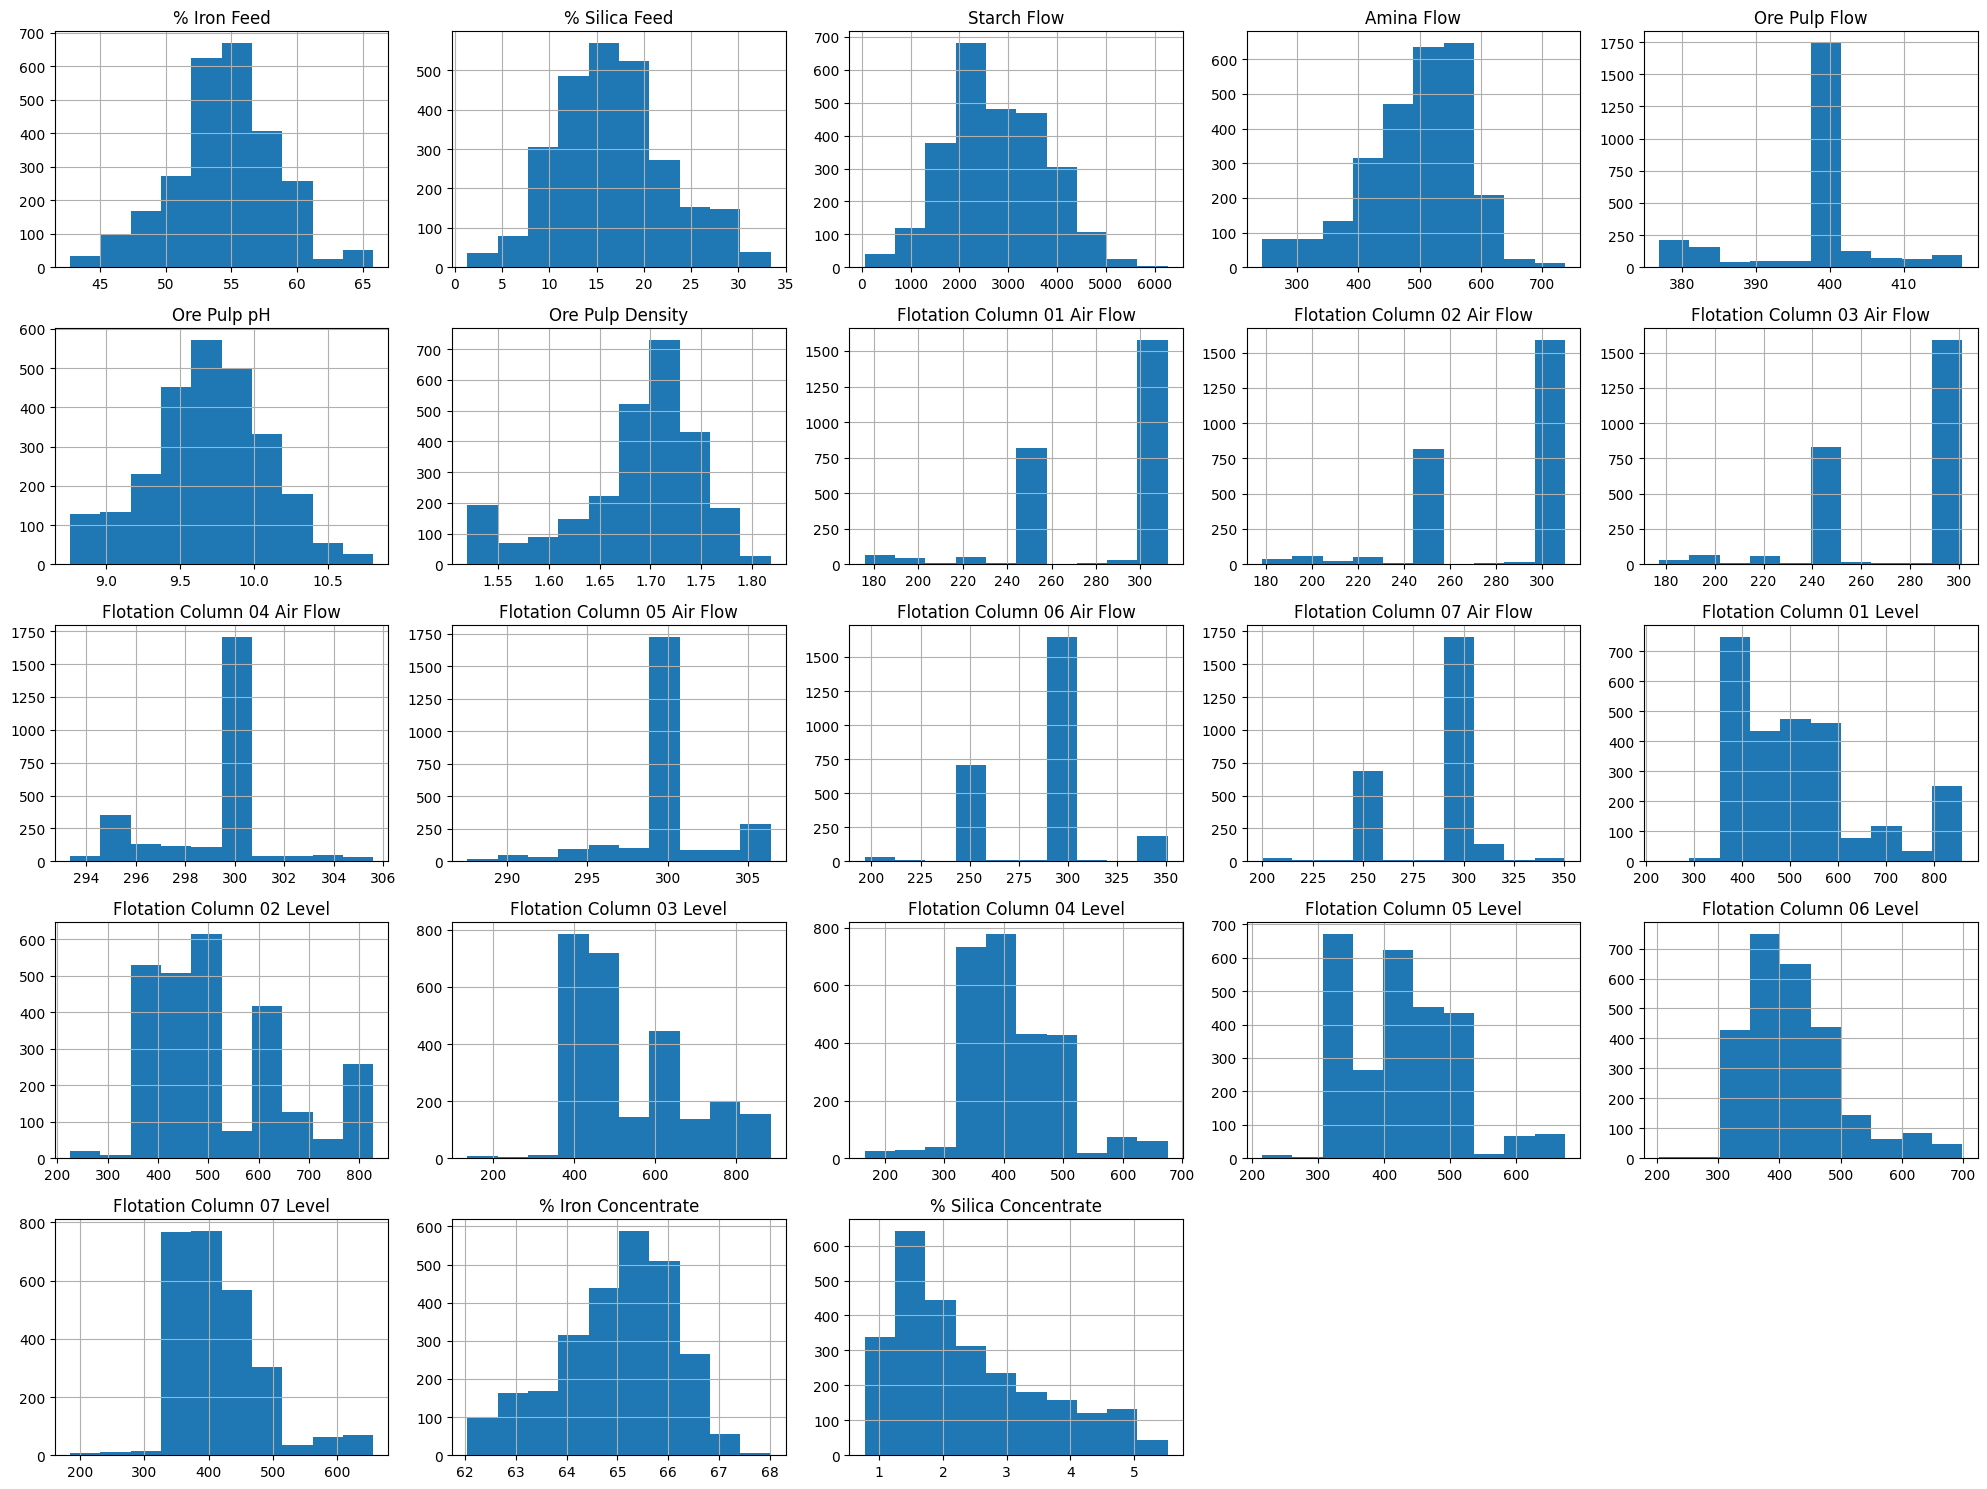

In [560]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
if figs_dir: plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

---

## Step 4. Model calibration

### Preparations

Our data modeling process begins from splitting the data to training, validation and test sets. Then we train the dynamic model on


We start by defining the predicted variable and the predictor variables:

**NOTE!** '% Iron Concentrate' is dropped as it can't be used (A-level task).

In [561]:
TARGET_COLUMN = '% Silica Concentrate'
DROP_COLUMNS = ['date']

#most_corr = data_corr[TARGET_COLUMN][data_corr[TARGET_COLUMN].abs() > 0.15]
#feature_columns = [c for c in most_corr.index if c not in ['date', '% Iron Concentrate', TARGET_COLUMN]]

feature_columns = [c for c in data.columns if c not in [*DROP_COLUMNS, TARGET_COLUMN]]
print(feature_columns)

['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow', 'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level', '% Iron Concentrate']


We split the data to training set, validation set and test set. The time series data is divided into 3 distinct windows (we dropped the unusable windows in Data Pretreatment), which gives us a natural way to split the data to the 3 sets. The start and end dates of these time windows are stored in the `start_dates` and `end_dates` arrays, which we can use to split the dataset. 

In [562]:
from math import floor

# Extract usable time windows from the data
data1, data2, data3 = [data.loc[(data.index > w['start']) & (data.index < w['end'])] for w in good_windows]

# train_size, val_size, test_size = 0.7, 0.15, 0.15
# train_end = floor(train_size * len(data))
# val_end = train_end + floor(val_size * len(data))

# # Split the data to training, validation and test sets
# data_train, data_val, data_test = data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]
print(data1.shape, data2.shape, data3.shape)

(1054, 23) (958, 23) (598, 23)


We split the data to sets of $X$ and $y$ and scale the data. 

In [563]:
from sklearn.preprocessing import StandardScaler

# Split the training, validation and test sets to sets X and y
X_train1, y_train1 = data1[feature_columns], data1[TARGET_COLUMN]
X_train2, y_train2 = data2[feature_columns], data2[TARGET_COLUMN]
X_test, y_test = data3[feature_columns], data3[TARGET_COLUMN]

# Normalize X_train 
# scaler_X, scaler_y = StandardScaler(), StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val, X_test = scaler_X.transform(X_val), scaler_X.transform(X_test)
# #y_train = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
# #y_val, y_test = scaler_y.transform(y_val.to_numpy().reshape(-1, 1)), scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# # Convert arrays back to DataFrames
# X_train, X_val, X_test = [pd.DataFrame(X, columns=feature_columns) for X in [X_train, X_val, X_test]]
# #y_train, y_val, y_test = [pd.DataFrame(y, columns=[TARGET_COLUMN]) for y in [y_train, y_val, y_test]]

#### Adding lagged variables

We implement a function `make_lagged` for adding lagged variables as new columns to dataset `X`. If both `X` and `y` are passed, `y` the top rows are cut so that `X` and `y` are the same length. The added lags can be changed by passing the array `lags` and the columns which lagged variables are added for can be changed by passing `columns`. 

In [564]:
def make_lagged(X: np.ndarray, y: np.ndarray|None=None, lags: np.ndarray=None, columns: list|None=None) -> np.ndarray|tuple[np.ndarray, np.ndarray]:
    
    # By default return unlagged features and features with lag 1
    if lags is None: lags = np.array([0, 1])
    
    # By default add lagged variables for all columns
    if columns is None: columns = X.columns 

    # Create lagged variables and add them to X
    lagged_vars = [X] if min(lags) < 1 else []
    lagged_vars += [X[columns].shift(lag).add_suffix(f"_lag{lag}" if lag > 0 else "") for lag in lags if lag > 0]
    X_lagged = pd.concat(lagged_vars, axis=1).dropna(axis=0)

    # Return X, or if y was passed, X and y cut to the same length as X (from the top)
    if y is None: return X_lagged
    return X_lagged, y[max(lags):]

### Define the PLS model

We define the PLS model 

In [565]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

def PLSModel(num_components: int) -> PLSRegression: 
    pls = PLSRegression(n_components=num_components, scale=False)
    pipeline = Pipeline([('scaler', StandardScaler()), ('pls', pls)])
    model = TransformedTargetRegressor(
        regressor=pipeline,
        transformer=StandardScaler()
    )
    return model 

### Selecting the optimal number of latent variables and lags

We select the optimal number of lags by training the model with different number of lags and cross-validating the results

In [566]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

# Training parameters
max_lv = len(feature_columns)
min_lag = 0 # The minimum amount of lag; a value greater than 0 means the original variables are emitted
max_lag = 10 # The highest amount of lag 
selected_lags_range = [np.arange(min_lag, i) for i in range(min_lag + 1, max_lag + 1)]
num_components_range = np.arange(1, max_lv)
lagged_columns = X_train1.columns


# Result arrays
results = []

# Training data split and scoring
tscv = TimeSeriesSplit(n_splits=2)
root_mean_square_error = lambda y_true, y_pred : np.sqrt(mean_squared_error(y_true, y_pred))

# Cross validation datasets
cv_sets = [
    (X_train1, y_train1, X_train2, y_train2), 
    (X_train2, y_train2, X_train1, y_train1), 
    # (X_train1, y_train1, X_test, y_test), 
    # (X_test, y_test, X_train1, y_train1), 
    # (X_train2, y_train2, X_test, y_test), 
    # (X_test, y_test, X_train2, y_train2), 
]

# Loop over lags
for i, selected_lags in enumerate(selected_lags_range):

    # Make lagged cross-validation sets
    cv_sets_lagged = []
    for X_train, y_train, X_val, y_val in cv_sets: 

        # Add lagged variables to training and validation sets
        X_train_lagged, y_train_lagged = make_lagged(X_train, y_train, selected_lags, lagged_columns)
        X_val_lagged, y_val_lagged = make_lagged(X_val, y_val, selected_lags, lagged_columns)

        #################################################################################################################
        # IMPORTANT! drop the UNLAGGED '% Iron Concentrate' column
        X_train_lagged, X_val_lagged = X_train_lagged.drop(columns=['% Iron Concentrate']), X_val_lagged.drop(columns=['% Iron Concentrate'])
        #################################################################################################################

        # Add lagged sets to cross-validation sets array
        cv_sets_lagged.append((X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged))

    # Cross validate the model over different number of latent variables
    for j, num_components in enumerate(num_components_range):
        
        # Define model 
        model = PLSModel(num_components)

        # Prepare results arrays
        y_test_cv, y_pred_cv = [], []

        # Cross-validate model 
        for X_train, y_train, X_val, y_val in cv_sets_lagged: 
            
            # Fit the model 
            model.fit(X_train, y_train)

            # Predict the test set
            y_pred = model.predict(X_val)
            y_test_cv.append(y_val.to_numpy().reshape(-1, 1))
            y_pred_cv.append(y_pred.reshape(-1, 1))

        # Compute stats
        y_test_cv, y_pred_cv = np.concat(y_test_cv, axis=0), np.concat(y_pred_cv,  axis=0)
        PRESS = np.sum((y_test_cv - y_pred_cv) ** 2)
        TSS = np.sum((y_test_cv - np.mean(y_pred_cv)) ** 2)
        Q2 = 1 - PRESS / TSS if TSS != 0 else np.nan
        RMSE = root_mean_square_error(y_test_cv, y_pred_cv)
        
        # Store results
        results.append({
            "num_comps": num_components, 
            "num_lags": selected_lags[-1], 
            "PRESS": PRESS, 
            "Q2": Q2,
            "RMSE": RMSE
        })

results = pd.DataFrame(results)
print(results.head())

   num_comps  num_lags        PRESS        Q2      RMSE
0          1         0  3393.693339 -0.338052  1.298740
1          2         0  3102.675515 -0.214697  1.241807
2          3         0  3078.890102 -0.215737  1.237038
3          4         0  3060.736680 -0.208724  1.233386
4          5         0  3272.966102 -0.290895  1.275430


### Visualize cross-validation results

We visualize cross-validation results with PRESS, Q2 and RMSE plots to make model selection easier. 

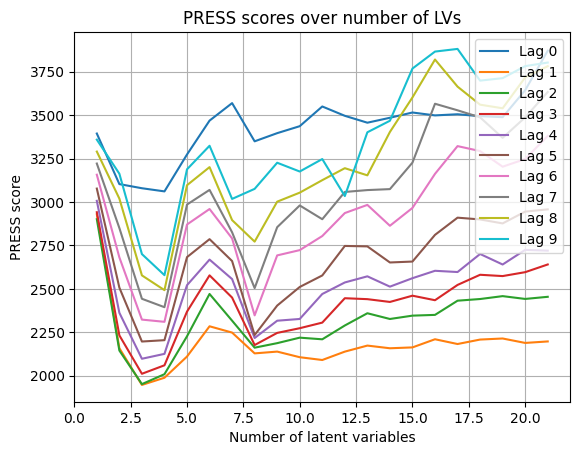

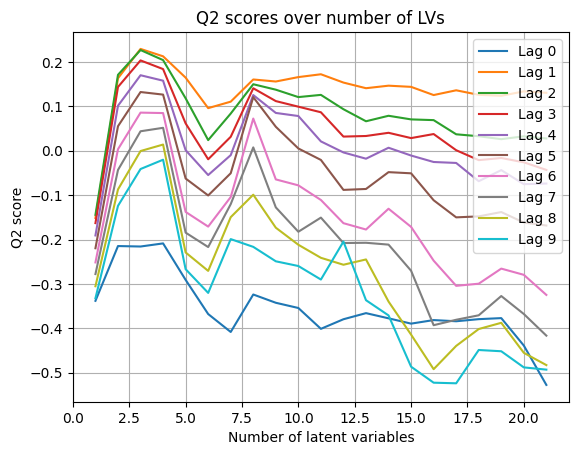

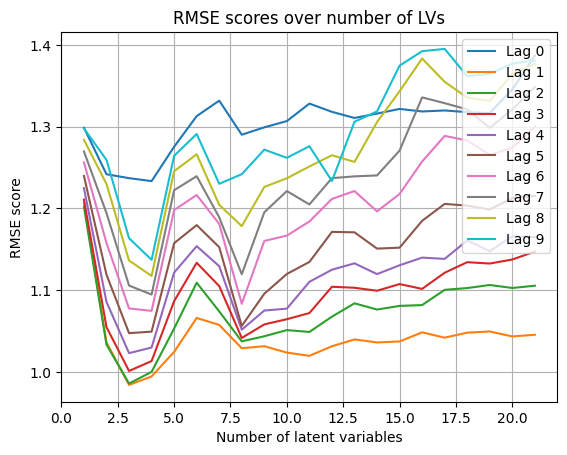

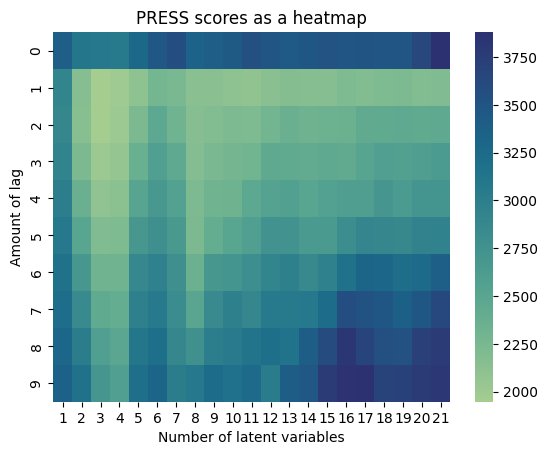

In [567]:
# PRESS scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['PRESS'], label=f'Lag {num_lags}')
plt.title("PRESS scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("PRESS score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"PRESS_cross_validation.png"), dpi=300)
plt.show()

# Q2 scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['Q2'], label=f'Lag {num_lags}')
plt.title("Q2 scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("Q2 score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"Q2_cross_validation.png"), dpi=300)
plt.show()

# RMSE scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['RMSE'], label=f'Lag {num_lags}')
plt.title("RMSE scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("RMSE score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"RMSE_cross_validation.png"), dpi=300)
plt.show()

# PRESS scores as a heatmap
pivot_press = results.pivot(index='num_lags', columns='num_comps', values='PRESS')
sns.heatmap(pivot_press.astype(float), cmap="crest", 
    xticklabels=num_components_range,
    yticklabels=[selected_lags[-1] for selected_lags in selected_lags_range],
)
plt.xlabel('Number of latent variables')
plt.ylabel('Amount of lag')
plt.title(f"PRESS scores as a heatmap")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"PRESS_heatmap.png"), dpi=300)
plt.show()

---

## Step 5. Model validation

We choose calibrated model parameters and cross validate model performance using k-folds cross validation

Best by PRESS: model 23, best by Q2: model 23
num_comps       3.000000
num_lags        1.000000
PRESS        1946.973256
Q2              0.229232
RMSE            0.984197
Name: 23, dtype: float64
[[-2.21006991e-02  2.34191138e-04 -2.82010454e-02  4.85332411e-02
   1.40601475e-02 -2.83964205e-02 -4.76448939e-02 -2.16478151e-02
  -5.33464793e-03 -1.53028854e-02  1.38053093e-01 -3.09621895e-02
  -1.88610584e-02 -2.26803633e-02 -8.58076493e-03 -3.79836508e-02
  -2.40370827e-02  5.64873356e-02 -5.30962765e-02  3.60835645e-02
  -9.56536543e-03 -7.79950458e-03 -1.12373095e-02 -1.39901565e-02
   4.53279441e-02  1.99496334e-02 -6.03635835e-02 -1.86731696e-02
  -2.38149508e-02 -7.33943543e-03 -1.70089371e-02  1.43681139e-01
  -3.49280334e-02 -2.05726992e-02 -2.41085151e-02  1.44557580e-03
  -4.24544548e-02 -2.04191210e-02  6.36910830e-02 -5.79903366e-02
   4.41783355e-02  3.73389559e-04 -6.03211144e-01]]


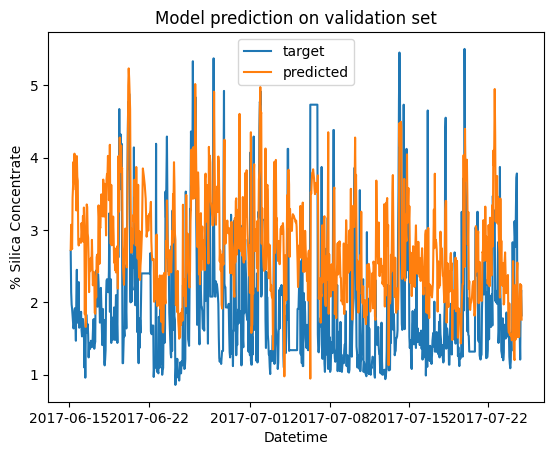

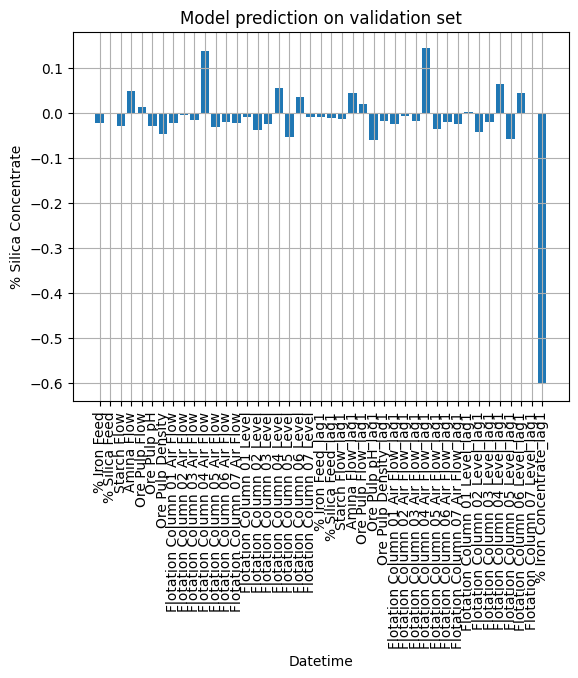

In [570]:
# Choose best model parameters according to PRESS
i = results['PRESS'].argmin()
j = results['Q2'].argmax()
print(f"Best by PRESS: model {i}, best by Q2: model {j}")
row = results.iloc[i] 
print(row)

# Best model parameters
num_components, max_lag = row['num_comps'].astype(int), row['num_lags']
selected_lags = np.arange(0, max_lag + 1).astype(int)
selected_cols = feature_columns

# Create lagged datasets
X_train_lagged, y_train_lagged = make_lagged(X_train1, y_train1, selected_lags, selected_cols)
X_val_lagged, y_val_lagged = make_lagged(X_train2, y_train2, selected_lags, selected_cols)

#################################################################################################################
# IMPORTANT! drop the UNLAGGED '% Iron Concentrate' column
X_train_lagged, X_val_lagged = X_train_lagged.drop(columns=['% Iron Concentrate']), X_val_lagged.drop(columns=['% Iron Concentrate'])
#################################################################################################################

scaler = StandardScaler()
X_train_lagged = pd.DataFrame(scaler.fit_transform(X_train_lagged), columns=X_train_lagged.columns)
X_val_lagged = pd.DataFrame(scaler.fit_transform(X_val_lagged),  columns=X_train_lagged.columns)

# Train model with optimal parameters
model = PLSRegression(num_components)
model.fit(X_train_lagged, y_train_lagged)
print(model.coef_)

# Predict the validation set
y_pred = model.predict(X_val_lagged)

# Plot the prediction
x_test = np.arange(0, len(y_pred))
plt.figure()
plt.plot(y_val_lagged.index, y_val_lagged, label='target')
plt.plot(y_val_lagged.index, y_pred, label='predicted')
plt.legend()
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_val_pred.png"), dpi=300)
plt.show()

# Plot model coefficients
plt.bar(X_train_lagged.columns.ravel(), model.coef_.flatten())
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
plt.xticks(rotation=90)
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_coefs.png"), dpi=300)
plt.show()

### Reducing model vars

We validate the model using the training and validation data 

---

## Step 6. Model testing 

Choose the best model, and apply it to the test set

In [569]:
pd.set_option('display.max_columns', None)
data_val.head()

NameError: name 'data_val' is not defined

In [ ]:
def make_lagged2(X, y, num_lags):
  hour_freq_vars = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate']
  columns_high_freq = list( X.columns.values.copy() )
  [columns_high_freq.remove(col) for col in hour_freq_vars]

  lagged_data = X.copy()
  for i in range(1, num_lags+1):
    lag_data = X[columns_high_freq].shift(i).add_suffix('.L' + str(i))
    lagged_data = pd.concat([lagged_data, lag_data], axis=1)

  return lagged_data.dropna(axis=0), y[num_lags:]

X_r, y_r = make_lagged2(X_val, y_val, 2)
X_r.head()

In [ ]:
y_r